In [1]:
import numpy as np
import cvxpy as cp 
from matplotlib import pyplot as plt
from rcracers.utils.geometry import Polyhedron, Ellipsoid, plot_polytope, plot_ellipsoid
from rcracers.utils.lqr import dlqr

from given3.problem import Problem
%config InlineBackend.figure_formats = ['svg'] 

# Session 3: Terminal Ingredients

## Assignment 2

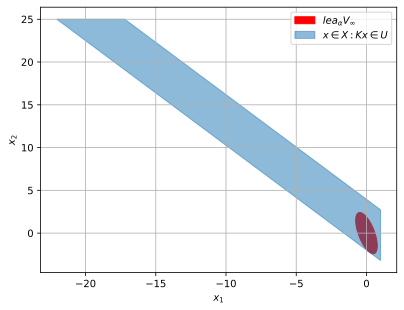

In [2]:
def state_bound_set(problem: Problem):
    I = np.eye(2)
    H = np.vstack([I, -I])
    g = np.array([problem.p_max, problem.v_max, -problem.p_min, -problem.v_min])

    polyhedral_set = Polyhedron.from_inequalities(H,g)
    return polyhedral_set

def input_bound_set(problem: Problem, K: np.ndarray):
    H = np.array([1.0, -1.0]).reshape([-1,1]) @ K
    g = np.array([problem.u_max, -problem.u_min])

    polyhedral_set = Polyhedron.from_inequalities(H,g)
    return polyhedral_set

def max_ellipse(poly: Polyhedron, P: np.ndarray):
    d = poly.H.shape[0]
    H = poly.H
    g = poly.h 

    Pi = np.linalg.inv(P)

    a_min = np.inf
    for i in range(d):
        hi = H[i,:].reshape([-1,1])
        a = (g[i] ** 2) / (hi.T @ Pi @ hi)
        if a < a_min:
            a_min = a 

    return Ellipsoid(shape_matrix=P / (a_min))

# Plot of the polyhedral set
problem = Problem()
lqrsol = dlqr(problem.A, problem.B, problem.Q, problem.R)
state_set = state_bound_set(problem)
input_set = input_bound_set(problem, lqrsol.K)
max_set = state_set.intersect(input_set)
max_ell = max_ellipse(max_set, lqrsol.P)

plt.figure() 
ax = plt.gca()
plot_ellipsoid(max_ell, label=r"${lea_\alpha V_\infty}$", color="r")
plot_polytope(max_set, label=r"${x \in X: Kx \in U}$")
plt.legend()
plt.grid()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.savefig("figs/3.2-1.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

## Assignment 3.7

(CVXPY) Jan 11 09:43:16 PM: Your problem has 6 variables, 38 constraints, and 0 parameters.
(CVXPY) Jan 11 09:43:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 11 09:43:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 11 09:43:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 11 09:43:16 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jan 11 09:43:16 PM: Compiling problem (target solver=SCS).
(CVXPY) Jan 11 09:43:16 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jan 11 09:43:16 PM: Applying reduction FlipObjective
(CVXPY) Jan 11 09:43:16 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 11 09:43:16 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 11 09:43:16 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jan 11 09:43:16 PM: Applying reduc

                                     CVXPY                                     
                                     v1.7.5                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
------------------------------------------------------------------
	       SCS v3.2.10 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 10, constraints m: 45
cones: 	  l: linear vars: 4
	  s: psd vars: 35, ssize: 5
	  e: exp vars: 6, dual exp 

(CVXPY) Jan 11 09:43:19 PM: Problem status: optimal
(CVXPY) Jan 11 09:43:19 PM: Optimal value: 2.083e+00
(CVXPY) Jan 11 09:43:19 PM: Compilation took 3.944e-02 seconds
(CVXPY) Jan 11 09:43:19 PM: Solver (including time spent in interface) took 3.174e+00 seconds


 74500| 3.83e-02  6.78e-05  1.58e-01 -2.02e+00  8.96e-03  3.13e+00 
 74750| 3.02e-02  5.78e-05  1.19e-01 -2.03e+00  8.96e-03  3.14e+00 
 75000| 4.47e-03  1.10e-05  1.85e-02 -2.07e+00  8.96e-03  3.15e+00 
 75250| 1.03e-03  2.32e-06  3.88e-03 -2.08e+00  8.96e-03  3.16e+00 
 75500| 9.44e-05  1.71e-07  4.55e-04 -2.08e+00  8.96e-03  3.17e+00 
 75625| 5.53e-05  2.92e-08  7.31e-06 -2.08e+00  8.96e-03  3.17e+00 
------------------------------------------------------------------
status:  solved
timings: total: 3.17e+00s = setup: 1.13e-03s + solve: 3.17e+00s
	 lin-sys: 6.07e-02s, cones: 3.03e+00s, accel: 1.45e-02s
------------------------------------------------------------------
objective = -2.082703
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
------------------------------------------------------------------------

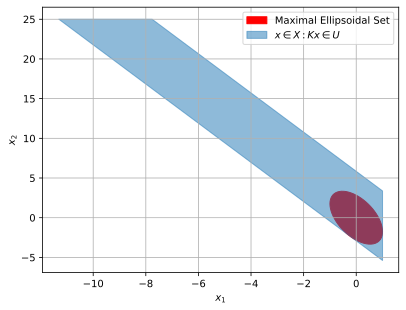

In [3]:
# Hu = input_set.H 
# hu = input_set.h 

Hu = np.array([1.0, -1.0]).reshape([-1,1])
hu = np.array([problem.u_max, -problem.u_min])

Hx = state_set.H 
hx = state_set.h 

nx = problem.A.shape[0]
nu = problem.B.shape[1]

S = cp.Variable((nx, nx), name="S", PSD=True)
F = cp.Variable((nu, nx), name="F")

A = problem.A 
B = problem.B 

constraints = []

# Invariance Constraint
constraints.append(cp.bmat([
    [S, (A@S + B@F).T],
    [A@S + B@F, S]
]) >> 0)

# state constraints
for i in range(Hx.shape[0]):
    Hi = Hx[i,:].reshape((-1,1))
    hi = hx[i]
    constraints.append(Hi.T @ S @ Hi <= hi**2)

# input constraints
for i in range(Hu.shape[0]):
    Hi = Hu[i,:].reshape((-1,1))
    hi = hu[i]
    constraints.append(cp.bmat([
        [np.array([[hi**2]]), Hi.T@F],
        [F.T@Hi, S]
    ]) >> 0)

objective = cp.Maximize(cp.log_det(S))
prob = cp.Problem(objective, constraints)
prob.solve(verbose=True)
S_opt = S.value
F_opt = F.value

# Recover P and K
P_opt = np.linalg.inv(S_opt)
K_opt = F_opt @ P_opt

print(K_opt)
print(P_opt)

input_set_new = input_bound_set(problem, K_opt)
max_set_new = state_set.intersect(input_set_new)
max_ell_new = max_ellipse(max_set_new, P_opt)

plt.figure() 
ax = plt.gca()
plot_ellipsoid(max_ell_new, label=r"Maximal Ellipsoidal Set", color="r")
plot_polytope(max_set_new, label=r"${x \in X: Kx \in U}$")
plt.legend()
plt.grid()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.savefig("figs/3.7-1.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()